In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
from sklearn.model_selection import TimeSeriesSplit

In [6]:
# Importing the Datasets
GlobalTemperatures = pd.read_csv('Data/GlobalTemperatures.csv', parse_dates=['dt'], index_col ='dt')

In [7]:
# Creating a new datasets for the average land temperature
GlobalTemperaturesAvg = GlobalTemperatures.copy()

# Dropping NaN values
GlobalTemperaturesAvg = GlobalTemperaturesAvg.dropna()

# Cleaning the dataset to only include the necessary data
LandDrop = ['LandAverageTemperatureUncertainty',
           'LandMaxTemperature',
           'LandMaxTemperatureUncertainty',
           'LandMinTemperature',
           'LandMinTemperatureUncertainty',
           'LandAndOceanAverageTemperature',
           'LandAndOceanAverageTemperatureUncertainty']

GlobalTemperaturesAvg.drop(LandDrop, inplace=True, axis=1)
GlobalTemperaturesAvg.tail(10)

,LandAverageTemperature
dt,
2015-03-01,6.740
2015-04-01,9.313
2015-05-01,12.312
2015-06-01,14.505
2015-07-01,15.051
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801
2015-11-01,7.433


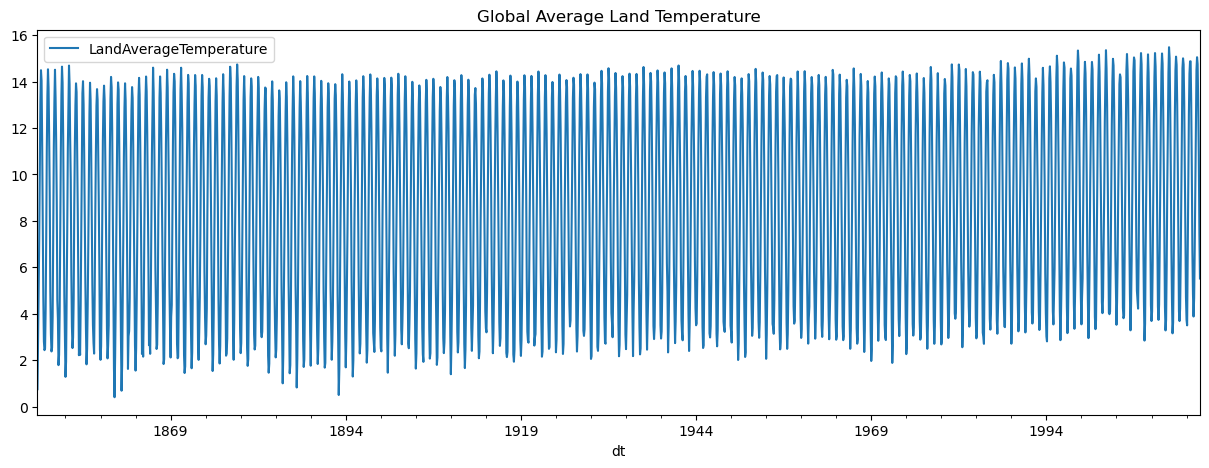

In [12]:
# Plotting the data
GlobalTemperaturesAvg.plot(style='-',
                          figsize=(15,5),
                          color=color_pal[0],
                          title='Global Average Land Temperature')
plt.show()

<Axes: ylabel='Frequency'>

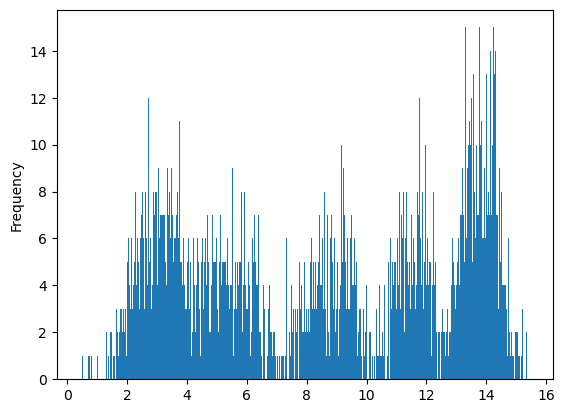

In [13]:
# GlobalTemperaturesAvg['LandAverageTemperature'].plot(kind='hist', bins=500)

<Axes: xlabel='dt'>

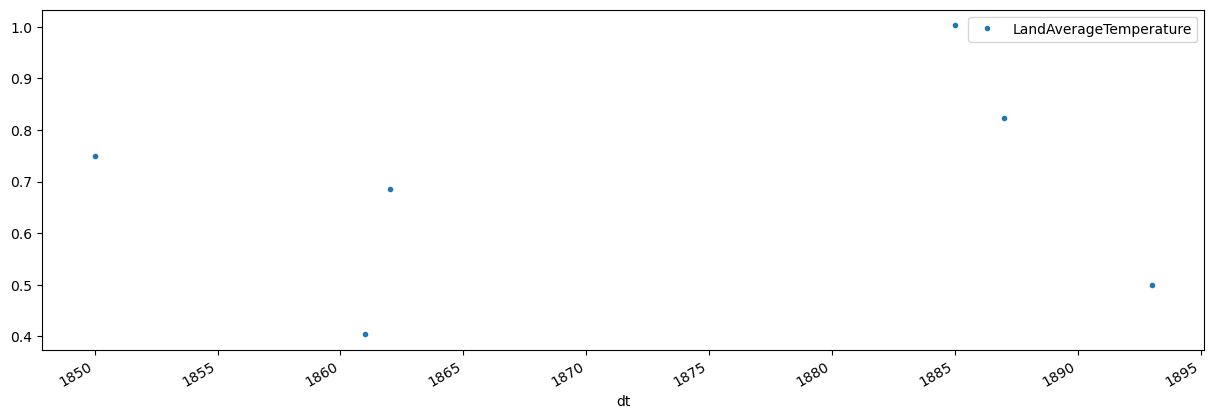

In [15]:
# GlobalTemperaturesAvg.query('LandAverageTemperature < 1.2').plot(figsize=(15,5), style='.')

In [36]:
# Time Series Cross Validation

split = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)
GlobalTemperaturesAvg = GlobalTemperaturesAvg.sort_index()

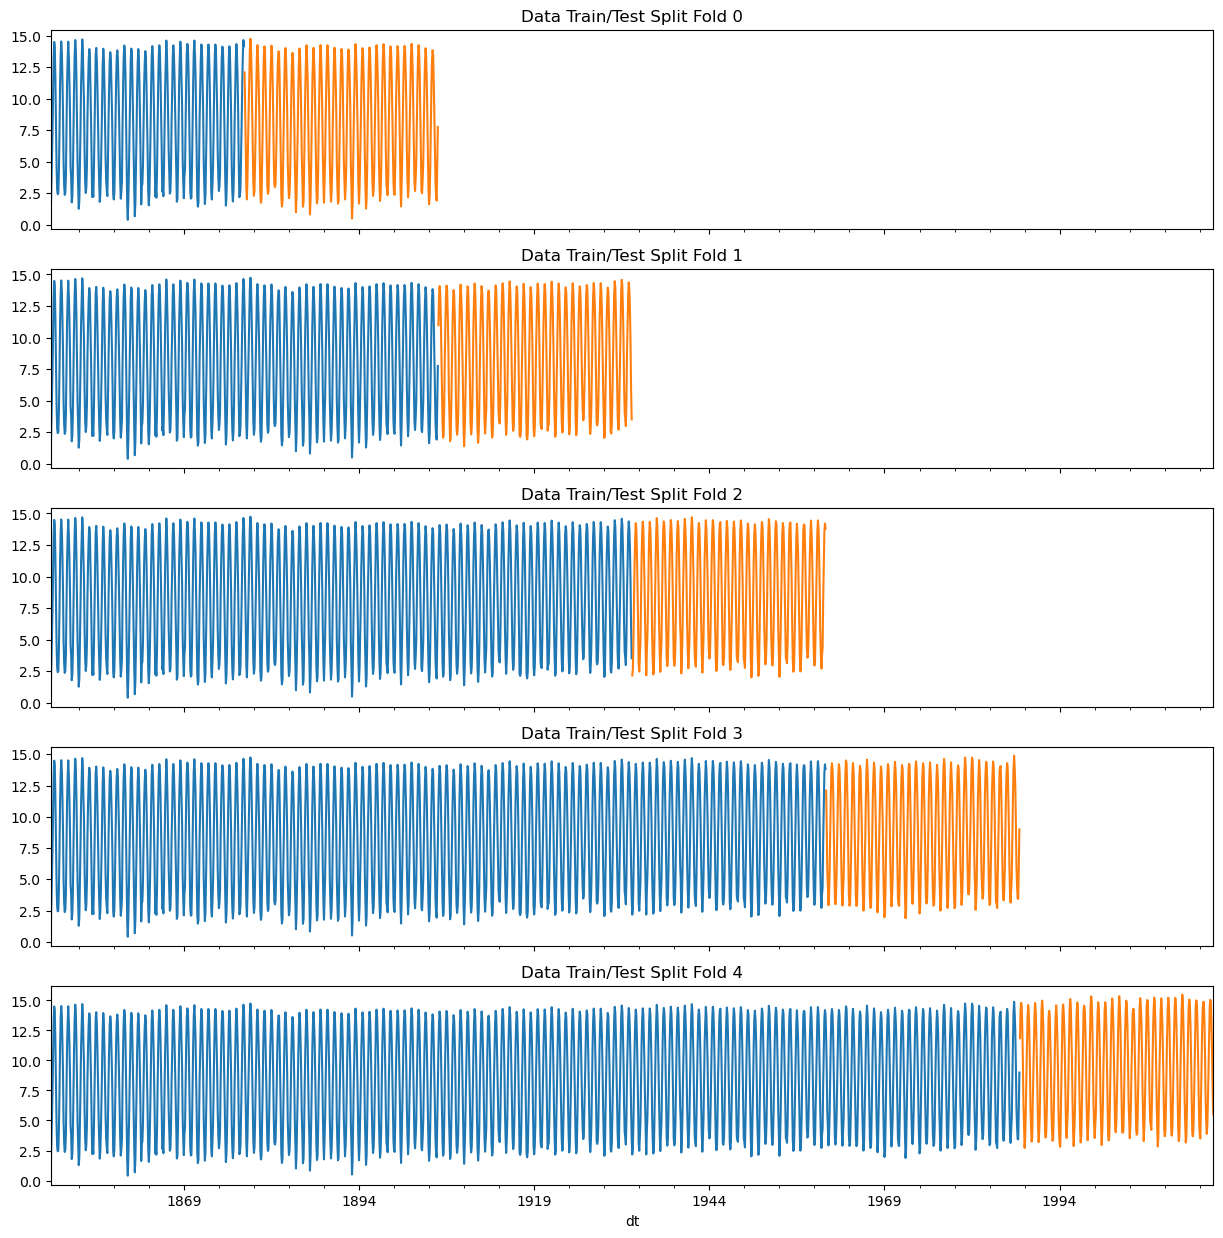

In [37]:
# Visualizing the cross validation

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in split.split(GlobalTemperaturesAvg):
    train = GlobalTemperaturesAvg.iloc[train_idx]
    test = GlobalTemperaturesAvg.iloc[val_idx]
    train['LandAverageTemperature'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['LandAverageTemperature'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [40]:
# Splitting the date up into different features
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

GlobalTemperaturesAvg = create_features(GlobalTemperaturesAvg)
GlobalTemperaturesAvg.head(10)

,LandAverageTemperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
dt,,,,,,,,,
1850-01-01,0.749,0,1,1,1,1850,1,1,1
1850-02-01,3.071,0,4,1,2,1850,32,1,5
1850-03-01,4.954,0,4,1,3,1850,60,1,9
1850-04-01,7.217,0,0,2,4,1850,91,1,14
1850-05-01,10.004,0,2,2,5,1850,121,1,18
1850-06-01,13.150,0,5,2,6,1850,152,1,22
1850-07-01,14.492,0,0,3,7,1850,182,1,27
1850-08-01,14.039,0,3,3,8,1850,213,1,31
1850-09-01,11.505,0,6,3,9,1850,244,1,35


In [63]:
# Creating Lag Features
def lags(df):
    target_map = df['LandAverageTemperature'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1826 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('3652 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('5478 days')).map(target_map)
    return df

In [65]:
GlobalTemperaturesAvg = lags(GlobalTemperaturesAvg)
GlobalTemperaturesAvg.tail()

,LandAverageTemperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
dt,,,,,,,,,,,,
2015-08-01,14.755,0,5,3,8,2015,213,1,31,14.768,14.510,14.519
2015-09-01,12.999,0,1,3,9,2015,244,1,36,12.863,13.217,12.547
2015-10-01,10.801,0,3,4,10,2015,274,1,40,10.442,10.601,9.486
2015-11-01,7.433,0,6,4,11,2015,305,1,44,7.487,7.423,6.312
2015-12-01,5.518,0,1,4,12,2015,335,1,49,4.292,4.878,3.863


In [68]:
# Training the Cross Validation

split = TimeSeriesSplit(n_splits=5, test_size=None, gap=0)
GlobalTemperaturesAvg = GlobalTemperaturesAvg.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in split.split(GlobalTemperaturesAvg):
    train = GlobalTemperaturesAvg.iloc[train_idx]
    test = GlobalTemperaturesAvg.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'LandAverageTemperature'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:8.72400	validation_1-rmse:8.67309
[100]	validation_0-rmse:3.34512	validation_1-rmse:3.31653
[200]	validation_0-rmse:1.33943	validation_1-rmse:1.32301
[300]	validation_0-rmse:0.65730	validation_1-rmse:0.64008
[400]	validation_0-rmse:0.45784	validation_1-rmse:0.44967
[500]	validation_0-rmse:0.39396	validation_1-rmse:0.42567
[582]	validation_0-rmse:0.36987	validation_1-rmse:0.42649
[0]	validation_0-rmse:8.69817	validation_1-rmse:8.90970
[100]	validation_0-rmse:3.31437	validation_1-rmse:3.47440
[200]	validation_0-rmse:1.31486	validation_1-rmse:1.44194
[300]	validation_0-rmse:0.64342	validation_1-rmse:0.72255
[400]	validation_0-rmse:0.45551	validation_1-rmse:0.49535
[500]	validation_0-rmse:0.39899	validation_1-rmse:0.44969
[600]	validation_0-rmse:0.37052	validation_1-rmse:0.43940
[700]	validation_0-rmse:0.35485	validation_1-rmse:0.44003
[702]	validation_0-rmse:0.35451	validation_1-rmse:0.43987
[0]	validation_0-rmse:8.76853	validation_1-rmse:9.09757
[100]	validation_0-r

In [70]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.4255
Fold scores:[0.42376255960649073, 0.43794205514287426, 0.32815568152596086, 0.34500817364514924, 0.5927252892261093]


In [71]:
# Forecasting

# Retraining using all of the data, rather than the cross validation split
GlobalTemperaturesAvg = create_features(GlobalTemperaturesAvg)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'LandAverageTemperature'

X_all = GlobalTemperaturesAvg[FEATURES]
y_all = GlobalTemperaturesAvg[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=700,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:8.89551	validation_1-rmse:9.73741
[100]	validation_0-rmse:3.39351	validation_1-rmse:4.12113
[200]	validation_0-rmse:1.36736	validation_1-rmse:2.02665
[300]	validation_0-rmse:0.67512	validation_1-rmse:1.23405
[400]	validation_0-rmse:0.47100	validation_1-rmse:0.90769
[500]	validation_0-rmse:0.40938	validation_1-rmse:0.76407
[600]	validation_0-rmse:0.38123	validation_1-rmse:0.69923
[699]	validation_0-rmse:0.36245	validation_1-rmse:0.66646


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [100]:
# Creating dataframe that will contain predicted values
#GlobalTemperaturesAvg.index.max()

predicted = pd.date_range('2015-12-01', '2016-12-01', freq='MS')
predicted_df = pd.DataFrame(index=predicted)
predicted_df['isPredicted'] = True
GlobalTemperaturesAvg['isPredicted'] = False
GlobalTemperaturesAvg_predicted = pd.concat([GlobalTemperaturesAvg, predicted_df])
GlobalTemperaturesAvg_predicted = create_features(GlobalTemperaturesAvg_predicted)
GlobalTemperaturesAvg_predicted = lags(GlobalTemperaturesAvg_predicted)

In [101]:
predicted_features = GlobalTemperaturesAvg_predicted.query('isPredicted').copy()
predicted_features

,LandAverageTemperature,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isPredicted
2015-12-01,NaN,0,1,4,12,2015,335,1,49,4.292,4.878,3.863,True
2016-01-01,NaN,0,4,1,1,2016,1,1,53,3.282,3.286,3.336,True
2016-02-01,NaN,0,0,1,2,2016,32,1,5,3.743,4.430,3.720,True
2016-03-01,NaN,0,1,1,3,2016,61,1,9,NaN,NaN,NaN,True
2016-04-01,NaN,0,4,2,4,2016,92,1,13,NaN,NaN,NaN,True
2016-05-01,NaN,0,6,2,5,2016,122,1,17,NaN,NaN,NaN,True
2016-06-01,NaN,0,2,2,6,2016,153,1,22,NaN,NaN,NaN,True
2016-07-01,NaN,0,4,3,7,2016,183,1,26,NaN,NaN,NaN,True
2016-08-01,NaN,0,0,3,8,2016,214,1,31,NaN,NaN,NaN,True
2016-09-01,NaN,0,3,3,9,2016,245,1,35,NaN,NaN,NaN,True


In [102]:
# Predicting
predicted_features['predicted'] = reg.predict(predicted_features[FEATURES])

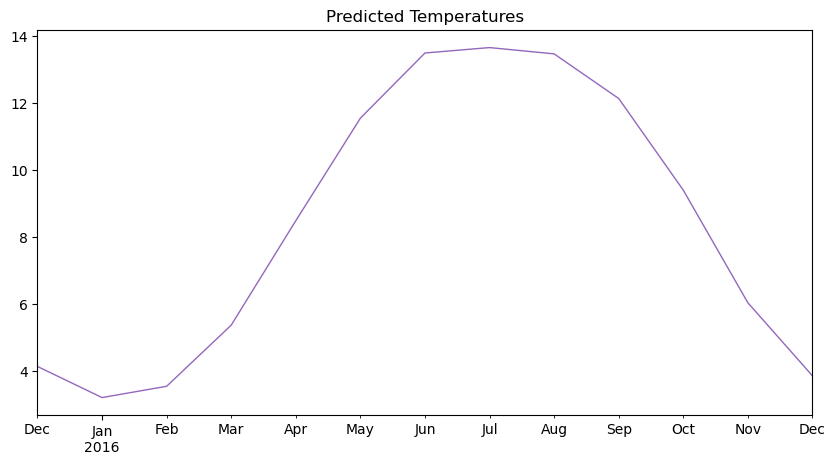

In [103]:
# Plotting predictions for the next year
predicted_features['predicted'].plot(figsize=(10, 5),
                                    color=color_pal[4],
                                    ms=1,
                                    lw=1,
                                    title = "Predicted Temperatures")
plt.show()